## Clustering: UCI Seed Dataset
https://archive.ics.uci.edu/ml/datasets/seeds

** Dataset Information: **

three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for the experiment

** Attribute Information:**

1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 

** Objective of this project **

cluster into 3 groups

## Data

In [1]:
import findspark
findspark.init('/home/danny/spark-2.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('seed').getOrCreate()

In [2]:
# Load Data
df = spark.read.csv('seeds_dataset.csv',inferSchema=True,header=True)
# Inspect Data
df.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)



In [3]:
df.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.175|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
only showing top 5 rows



In [4]:
df.head()

Row(area=15.26, perimeter=14.84, compactness=0.871, length_of_kernel=5.763, width_of_kernel=3.312, asymmetry_coefficient=2.221, length_of_groove=5.22)

In [5]:
df.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

## Data preprocessing

In [6]:
from pyspark.ml.feature import VectorAssembler,StandardScaler

** Format Input Data **

In [7]:
df.columns

['area',
 'perimeter',
 'compactness',
 'length_of_kernel',
 'width_of_kernel',
 'asymmetry_coefficient',
 'length_of_groove']

In [8]:
# combine features into a single column
assembler = VectorAssembler(inputCols=df.columns,outputCol='features')
final_data = assembler.transform(df)
final_data.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|            features|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|[15.26,14.84,0.87...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|[14.88,14.57,0.88...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|[14.29,14.09,0.90...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|[13.84,13.94,0.89...|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.17

** Scale the Data **

In [9]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
final_data = scaler.fit(final_data).transform(final_data)

## K-Means Clustering

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
%matplotlib inline

** Find Optimal K **

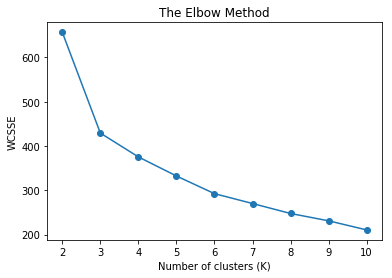

In [36]:
seed = 101
wcsse = np.zeros(len(range(2, 11)))
for i in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures',k=i, initMode='k-means||', seed=seed)
    model = kmeans.fit(final_data)
    #Within Set Sum of Squared Errors
    wcsse[i-2] = model.computeCost(final_data)
    
plt.plot(range(2, 11), wcsse, marker='o') #within-cluster sum of squares
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSSE')
plt.show()

** Train & Evaluate Model **

In [39]:
# Train model
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)

# Evaluate model
wssse = model.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 428.60820118716356


** Results **

In [12]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585013
 12.29286107]
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15410901
 10.38031464]
[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80061978
 10.41913733]


In [13]:
model.transform(final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         0|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         1|
+----------+
only showing top 20 rows



In [ ]:
spark.stop()